## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    for i, num in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=num, activation='relu')(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=num, activation='relu')(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation='softmax')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [16]:
# 載入 Callbacks
from tensorflow.keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    def __init__(self, validation_data):
        self.validation_data=validation_data
        
    def on_train_begin(self, epoch, logs = {}):
        logs = logs 
        records = ['val_tp','val_tn']
        for i in records:
            if i not in logs.keys():
                logs[i] = []
                
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs 
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:,1]>=thres)
        y_true = self.validation_data[1].argmax(axis=1)
        
        tp = sum((y_pred==1) & (y_true==1))
        tn = sum((y_pred==0) & (y_true==0))
        
        logs['val_tp'] = tp
        logs['val_tn'] = tn
        
rec_tptn = Record_tp_tn((x_test,y_test))

In [17]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test,y_test),
          shuffle=True,
          callbacks=[rec_tptn]
          )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024

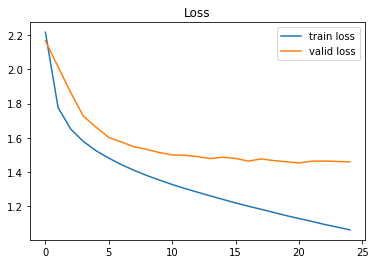

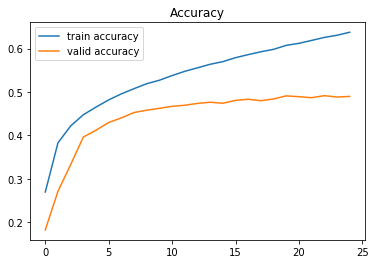

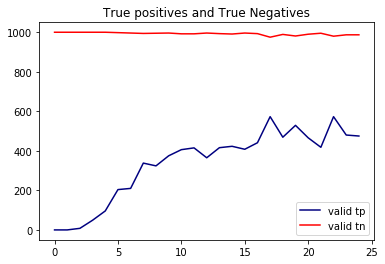

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
